Students:
* Ginevra Beltrame, 2130668
* Emanuele Coradin, 2124732
* Ada D'Iorio, 2092320
* Dario Liotta, 2124229

# Lecture

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import random
import time
from itertools import combinations

# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# XGBoost
#! pip install graphviz
#! pip install xgboost
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

#keras DNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from  keras.optimizers import Adam
import keras

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

2024-03-23 18:27:06.688421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 18:27:07.354666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


XGBoost version: 2.0.3


In [2]:
np.random.seed(12345)

#dname="/content/drive/MyDrive/LCP_projects/LCP - B/Ex3/DATA/"  #<--  only for Drive
dname=''
%cd DATA
str0="_XGB_24.dat"
fnamex='x'+str0
fnamey='y'+str0
x = np.loadtxt(dname + fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(dname + fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

/home/ubuntu/GitHub/Laboratory-of-Computational-Physics/Modulus B/Exercises/Ex3/DATA
N=4000, N_train=3000, L=4


/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


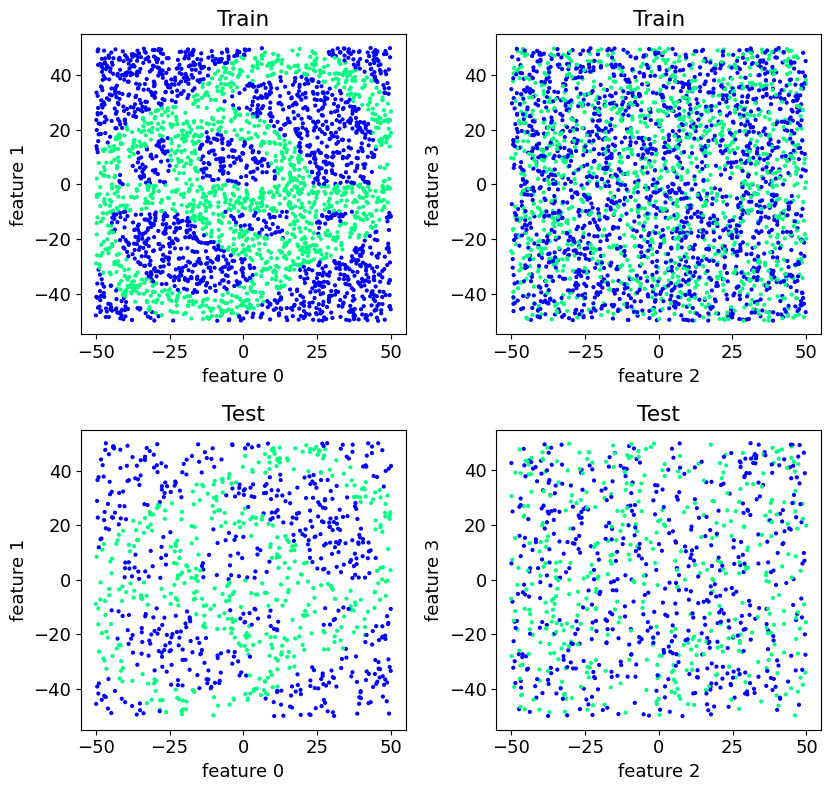

In [3]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [4]:
def classify(clf=GradientBoostingClassifier(),show=False, plot_flag = True, flag = False,  N_prime=x_train.shape[0], n_features = 4):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    x_classify = x_train[:N_prime,:n_features] 
    y_classify = y_train[:N_prime] 
    clf.fit(x_classify,y_classify)
    y_hat = clf.predict(x_test[:,:n_features])

    #print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,n_features))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)
    
    if flag:    
        return x_plot[:], y_plot, x_classify[:], y_classify
    
    if plot_flag:
        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()

    
    
    if show:
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)

        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        # fig.savefig("/content/drive/MyDrive/LCP_projects/LCP - B/Ex3/DATA/tree-classif.png", dpi=400, pad_inches=0.02)  <--  only for Drive
        fig.savefig("tree-classif.png", dpi=400, pad_inches=0.02)
        plt.show()

    return clf.score(x_test[:, :n_features], y_test)

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [5]:
model = XGBClassifier(seed=1, objective='binary:logistic')
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001,
       # n_estimators=30)

classify(model, show=True, flag = True)

(array([[-50., -50.,   0.,   0.],
        [-50., -49.,   0.,   0.],
        [-50., -48.,   0.,   0.],
        ...,
        [ 50.,  48.,   0.,   0.],
        [ 50.,  49.,   0.,   0.],
        [ 50.,  50.,   0.,   0.]]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([[-31.608, -29.544,   6.773,   9.554],
        [ 46.451,  15.318,  24.891,  15.357],
        [ 24.771,  46.131, -49.161, -39.356],
        ...,
        [ 36.665, -38.008,  35.986,  20.537],
        [ -7.26 , -42.905,  20.424,  37.988],
        [-35.435, -36.949,  16.395, -39.649]]),
 array([0, 1, 1, ..., 0, 1, 1]))

None
[0.4891835  0.37623835 0.06590363 0.06867457]


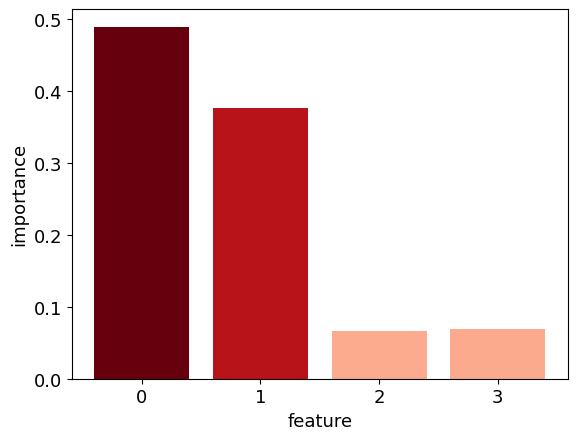

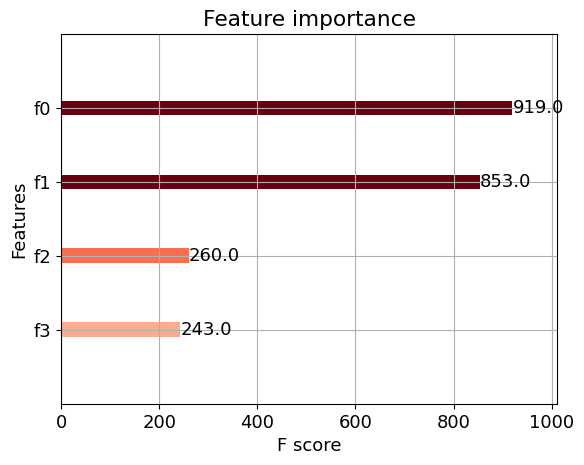

In [6]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))

plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [919. 853. 260. 243.]
1 gain [4.56883669 3.5139606  0.61552137 0.64140123]
2 total_gain [4198.76074219 2997.40844727  160.03555298  155.86050415]
3 cover [49.8643837  66.05692291 54.26316071 54.39147949]
4 total_cover [45825.3671875  56346.5546875  14108.421875   13217.12988281]


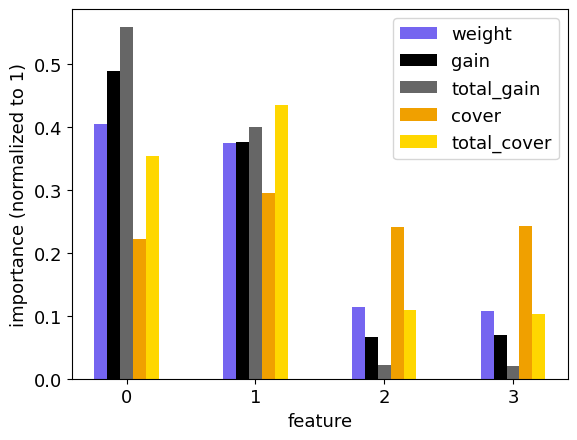

In [7]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## normal Gradient Boosting

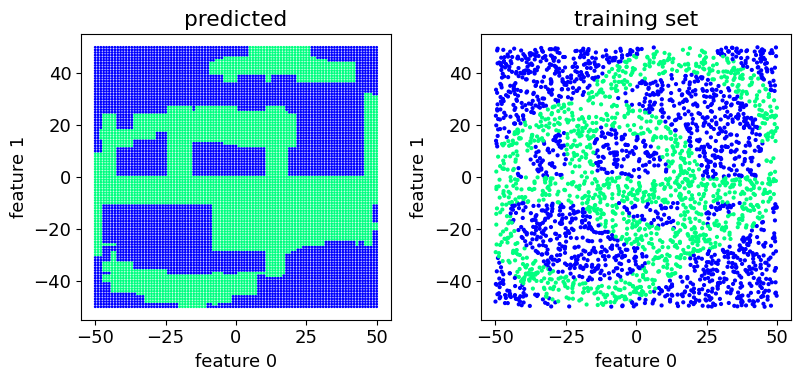

0.805

In [8]:
# GradientBoostingClassifier()
classify()

## AdaBoost

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


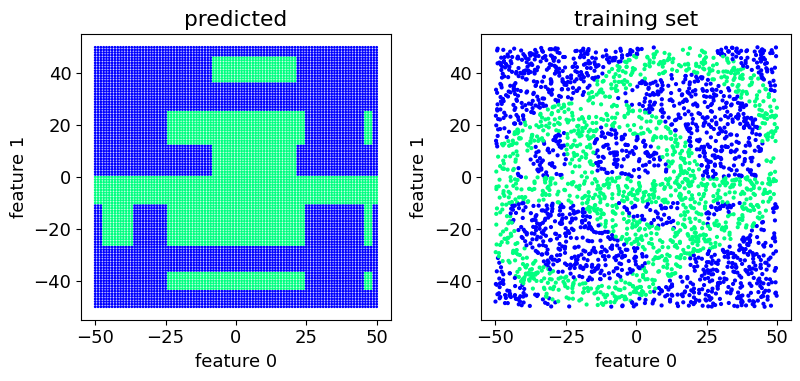

0.659

In [9]:
classify(clf=AdaBoostClassifier())

# Exercise

## Section 1 - Model complexity, parameters and regularization

In [7]:
def kfold_validation(clf, N_prime=int(x_train.shape[0]), n_features=4):
    kfold = KFold(n_splits=5, shuffle=True)
    
    # Define per-fold score containers
    scores_train = []
    scores_val = []
 
    x_val = x_train[:N_prime, :n_features]
    y_val = y_train[:N_prime]
    
    for train, val in kfold.split(x_val, y_val):
        # Fit data to model
        clf.fit(x_train[train, :n_features], y_train[train])

        # Evaluate the model
        scores = clf.score(x_train[val,:n_features], y_train[val]) #val
        scores_training = clf.score(x_train[train,:n_features], y_train[train]) #train

        scores_val.append(scores)
        scores_train.append(scores_training)

    return np.mean(scores_train), np.mean(scores_val)

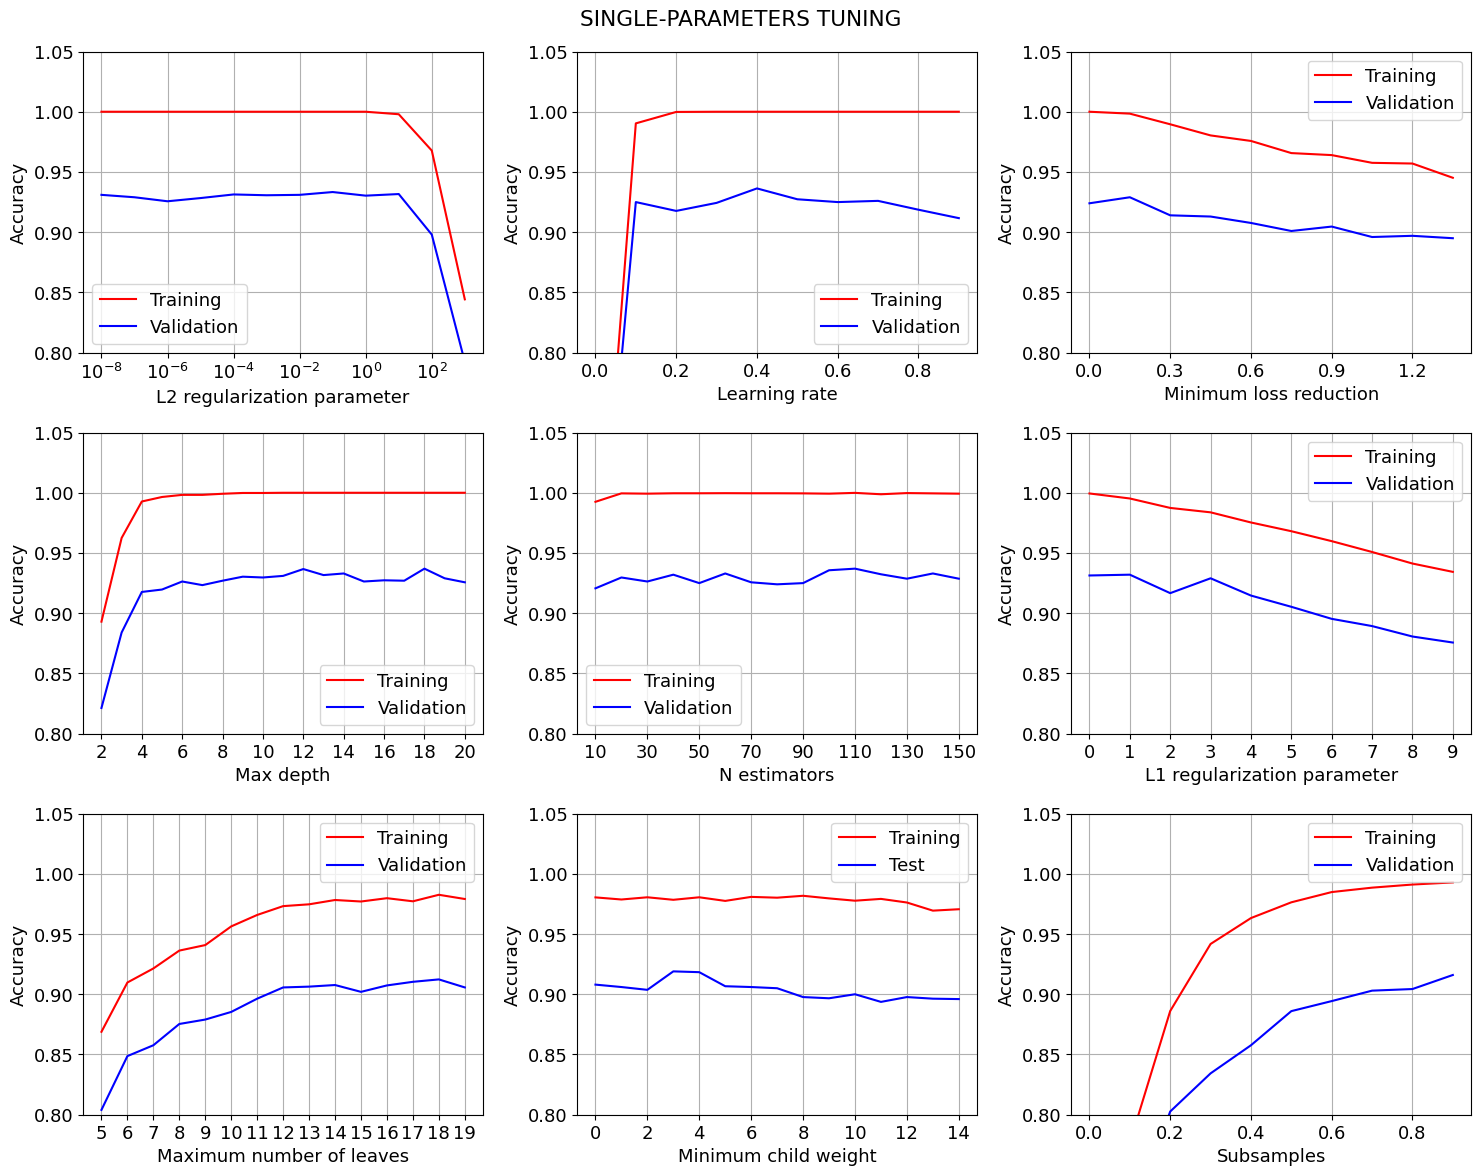

In [8]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle('SINGLE-PARAMETERS TUNING')

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

# Parameter 1: lambda (regularization L2)

lambdas = np.logspace(-8, 3, 12)
params = {}                         # dictionary of the best parameters of the model
PARAMS = {'reg_lambda': lambdas}    # dictionary of all the selected ranges of parameters for the model

accuracies1 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', reg_lambda=single_lambda)) for single_lambda in lambdas])

ax1.plot(lambdas, accuracies1[:,0], label='Training', color='r')
ax1.plot(lambdas, accuracies1[:,1], label='Validation', color='b')
ax1.set_xlabel('L2 regularization parameter')
ax1.set_ylabel('Accuracy')
ax1.set_xscale('log')
ax1.set_xticks(lambdas[::2])
ax1.legend()
ax1.set_ylim(0.8, 1.05)
ax1.grid(True)

best_lambda = lambdas[np.argmax(accuracies1[:,1])]
params['reg_lambda'] = best_lambda

# Parameter 2: eta (learning rate)

etas = np.arange(0, 1, 0.1)

accuracies2 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, learning_rate=eta)) for eta in etas])

ax2.plot(etas, accuracies2[:,0], label='Training', color='r')
ax2.plot(etas, accuracies2[:,1], label='Validation', color='b')
ax2.set_xlabel('Learning rate')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(etas[::2])
ax2.legend()
ax2.set_ylim(0.8, 1.05)
ax2.grid(True)

best_eta = etas[np.argmax(accuracies2[:,1])]
params['eta'] = best_eta
PARAMS['eta'] = etas

# Parameter 3: gamma (min_split_loss)

gammas = np.arange(0, 1.5, 0.15)

accuracies3 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, min_split_loss=gamma)) for gamma in gammas])

ax3.plot(gammas, accuracies3[:,0], label='Training', color='r')
ax3.plot(gammas, accuracies3[:,1], label='Validation', color='b')
ax3.set_xlabel('Minimum loss reduction')
ax3.set_ylabel('Accuracy')
ax3.set_xticks(gammas[::2])
ax3.legend()
ax3.set_ylim(0.8, 1.05)
ax3.grid(True)

best_gamma = gammas[np.argmax(accuracies3[:,1])]
params['gamma'] = best_gamma
PARAMS['gamma'] = gammas

# Parameter 4: max depth

max_depths = [int(i) for i in np.arange(2, 21, 1)]

accuracies4 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, max_depth=depth)) for depth in max_depths])

ax4.plot(max_depths, accuracies4[:,0], label='Training', color='r')
ax4.plot(max_depths, accuracies4[:,1], label='Validation', color='b')
ax4.set_xlabel('Max depth')
ax4.set_xticks([i for i in 2*np.arange(1,11,1)])
ax4.set_ylabel('Accuracy')
ax4.set_ylim(0.8, 1.05)
ax4.legend()
ax4.grid(True)

best_depth = 8          # we impose this parameter manually by looking at the graphs, in order to avoid obtaining an excessively complex model
params['max_depth'] = best_depth
PARAMS['max_depth'] = max_depths

# Parameter 5: n_estimators

ns_estimators = [int(i) for i in np.linspace(10,150,15)]

accuracies5 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, n_estimators=n)) for n in ns_estimators])

ax5.plot(ns_estimators, accuracies5[:,0], label='Training', color='r')
ax5.plot(ns_estimators, accuracies5[:,1], label='Validation', color='b')
ax5.set_xlabel('N estimators')
ax5.set_xticks(ns_estimators[::2])
ax5.set_ylabel('Accuracy')
ax5.set_ylim(0.8, 1.05)
ax5.legend()
ax5.grid(True)

params['n_estimators'] = 50     # we impose this parameter manually by looking at the graphs, in order to avoid obtaining an excessively complex model
PARAMS['n_estimators'] = ns_estimators

# Parameter 6: alpha (regularization L1)

alphas = np.arange(0, 10, 1)

accuracies6 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, reg_alpha = alpha)) for alpha in alphas])

ax6.plot(alphas, accuracies6[:,0], label='Training', color='r')
ax6.plot(alphas, accuracies6[:,1], label='Validation', color='b')
ax6.set_xlabel('L1 regularization parameter')
ax6.set_ylabel('Accuracy')
ax6.set_xticks(alphas)
ax6.legend()
ax6.set_ylim(0.8, 1.05)
ax6.grid(True)

best_alpha = alphas[np.argmax(accuracies6[:,1])]
params['reg_alpha'] = best_alpha
PARAMS['reg_alpha'] = alphas

# Parameter 7: max leaves

leaves = [int(i) for i in np.arange(5, 20 , 1)]

accuracies7 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, max_leaves = leave)) for leave in leaves])

ax7.plot(leaves, accuracies7[:,0], label='Training', color='r')
ax7.plot(leaves, accuracies7[:,1], label='Validation', color='b')
ax7.set_xlabel('Maximum number of leaves')
ax7.set_ylabel('Accuracy')
ax7.set_xticks(leaves)
ax7.legend()
ax7.set_ylim(0.8, 1.05)
ax7.grid(True)

best_leaves = leaves[np.argmax(accuracies7[:,1])]
params['max_leaves'] = best_leaves
PARAMS['max_leaves'] = leaves

# Parameter 8: Min child weight

min_child_weights = np.arange(0, 15, 1)

accuracies8 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, min_child_weight = child)) for child in min_child_weights])

ax8.plot(min_child_weights, accuracies8[:,0], label='Training', color='r')
ax8.plot(min_child_weights, accuracies8[:,1], label='Test', color='b')
ax8.set_xlabel('Minimum child weight')
ax8.set_ylabel('Accuracy')
ax8.set_xticks(min_child_weights[::2])
ax8.legend()
ax8.set_ylim(0.8, 1.05)
ax8.grid(True)

best_child = min_child_weights[np.argmax(accuracies8[:,1])]
params['min_child_weight'] = best_child
PARAMS['min_child_weight'] = min_child_weights

# Parameter 9: Subsampling

subsamples = np.arange(0, 1, 0.1)
accuracies9 = np.array([kfold_validation(XGBClassifier(seed=1, objective='binary:logistic', eval_metric = 'logloss', **params, subsample = sample)) for sample in subsamples])

ax9.plot(subsamples, accuracies9[:,0], label='Training', color='r')
ax9.plot(subsamples, accuracies9[:,1], label='Validation', color='b')
ax9.set_xlabel('Subsamples')
ax9.set_ylabel('Accuracy')
ax9.set_xticks(subsamples[::2])
ax9.legend()
ax9.set_ylim(0.8, 1.05)
ax9.grid(True)

best_samples = subsamples[np.argmax(accuracies9[:,1])]
params['subsample'] = best_samples
PARAMS['subsample'] = subsamples

plt.tight_layout()
plt.show()


By observing the above graphs, we are able to determine visually the most convenient values to assign some of the considered parameters. Specifically, we aim to avoid obtaining a model too complex to be speedily tested by our computational resources, but at the same time we want the kfold-cross validation accuracy to be as high as possible. To get this tradeoff, we choose the following values.

- $\lambda$ = 0 (no regulatization L2)
- $\alpha$ = 0 (no regulatization L1)
- max_depth = 8
- subsamples = 1
- n_estimators = 50
- min_child_weight = 3.5

It can be noted that without regularization the model is actually better.
We moreover redefine the ranges for the other three parameters as follows
- $\eta \in$ [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
- max_depth $\in$ [0.0, 0.1, 0.2]
- max_leaves $\in$ [12, 20] $\cap$ $\mathbb{N}$


and we perform a three-dimensional grid search over them.

In [9]:
PARAMS['reg_lambda'] = [0]
PARAMS['reg_alpha'] = [0]
PARAMS['max_depth'] = [8]
PARAMS['subsample'] = [1]
PARAMS['n_estimators'] = [50]
PARAMS['min_child_weight'] = [3.5]

PARAMS['eta'] = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
PARAMS['gamma'] = [i for i in np.arange(0.0, 0.3, 0.1)]
PARAMS['max_leaves'] = [i for i in np.arange(12, 21, 1)]

PARAMS

{'reg_lambda': [0],
 'eta': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
 'gamma': [0.0, 0.1, 0.2],
 'max_depth': [8],
 'n_estimators': [50],
 'reg_alpha': [0],
 'max_leaves': [12, 13, 14, 15, 16, 17, 18, 19, 20],
 'min_child_weight': [3.5],
 'subsample': [1]}

In [10]:
def tune_hyperparameters(clf, param_grid):
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

def evaluate_model(model, N_val=int(0.2*np.shape(x_train)[0])):
    model.fit(x_train[N_val:], y_train[N_val:])
    val_accuracy = model.score(x_train[:N_val], y_train[:N_val])
    return val_accuracy

xgb_model = XGBClassifier()

best_model = tune_hyperparameters(xgb_model, PARAMS)
val_accuracy = evaluate_model(best_model)
print("Accuracy:", np.round(val_accuracy,4))


best_parameters = best_model.get_params()

print('Best parameters: \n eta:\t\t', best_parameters['eta'], '\n gamma:\t\t', best_parameters['gamma'], '\n max_leaves:\t', best_parameters['max_leaves'])

Accuracy: 0.91
Best parameters: 
 eta:		 0.4 
 gamma:		 0.1 
 max_leaves:	 20


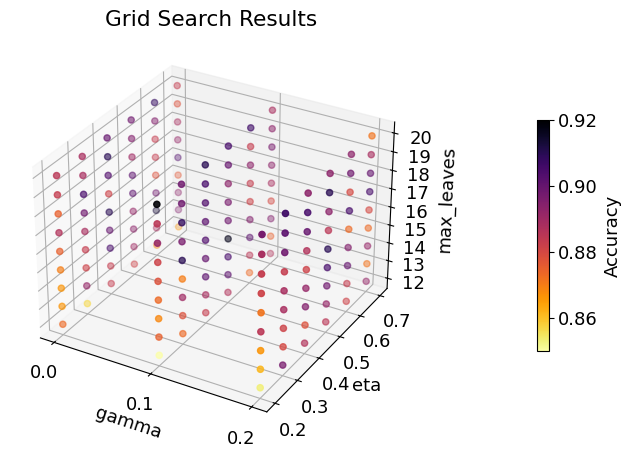

In [14]:
# 3D visualization of the parameter gridsearch
G, E, M = np.meshgrid(PARAMS['eta'], PARAMS['gamma'], PARAMS['max_leaves'])
A = np.ones(np.shape(E))

reduced_params = {}
reduced_params['reg_lambda'] = 0
reduced_params['reg_alpha'] = 0
reduced_params['max_depth'] = 8
reduced_params['subsample'] = 1
reduced_params['n_estimators'] = 50
reduced_params['min_child_weight'] = 3.5
N_val = int(0.2*np.shape(x_train)[0])


for i in range(len(PARAMS['gamma'])):
  for j in range(len(PARAMS['eta'])):
    for k in range(len(PARAMS['max_leaves'])):
      model = XGBClassifier(eta=PARAMS['eta'][j], gamma=PARAMS['gamma'][i], max_leaves=PARAMS['max_leaves'][k], **reduced_params)
      model.fit(x_train[N_val:], y_train[N_val:])
      A[i,j,k] = model.score(x_train[:N_val], y_train[:N_val])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection="3d")
scat_plot = ax.scatter(E,G,M, c=A, cmap='inferno_r', marker='o')
ax.set_xlabel('gamma')
ax.set_ylabel('eta')
ax.set_zlabel('max_leaves')
ax.set_xticks(PARAMS['gamma'])
ax.set_yticks(PARAMS['eta'])
ax.set_zticks(PARAMS['max_leaves'])
cbar = plt.colorbar(scat_plot, ax=ax, pad=0.2, shrink=0.5)
cbar.set_label('Accuracy')
plt.title('Grid Search Results')

plt.show()

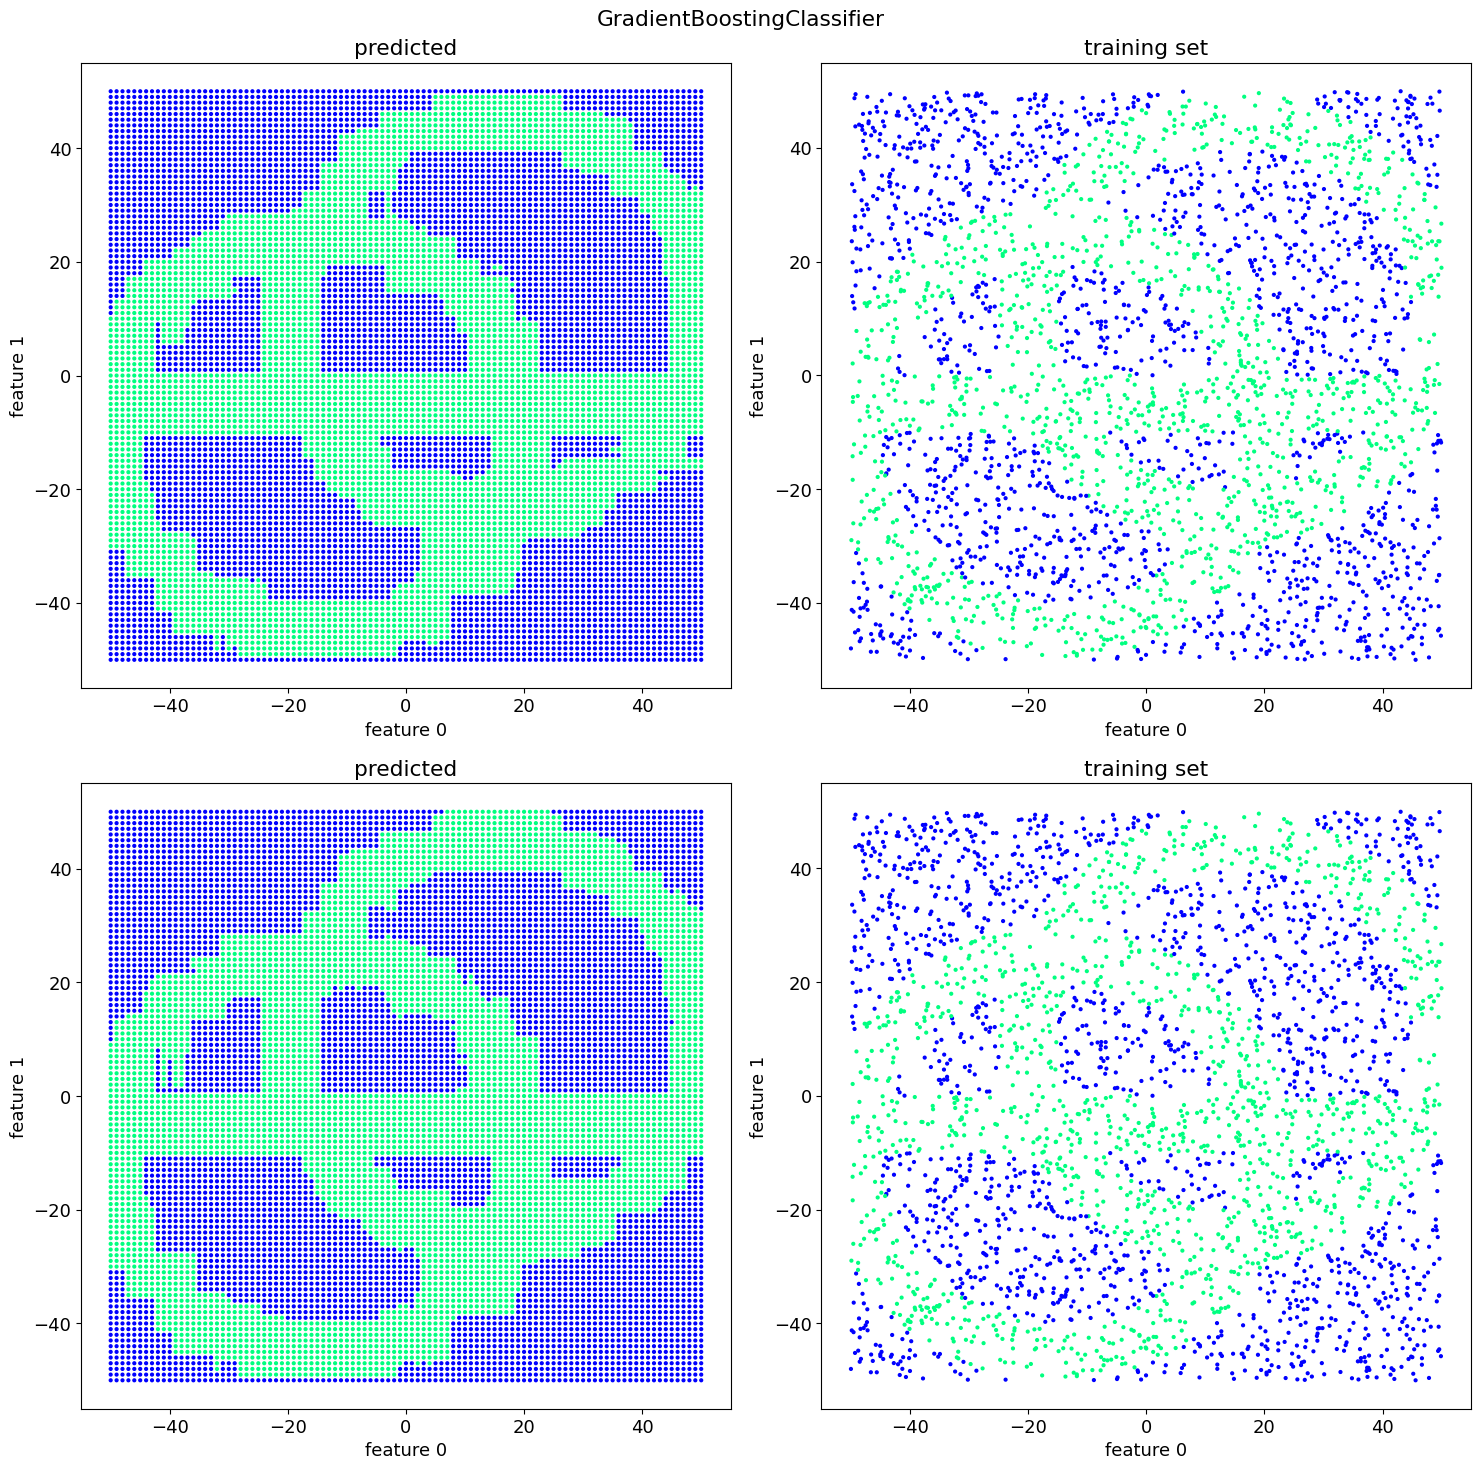

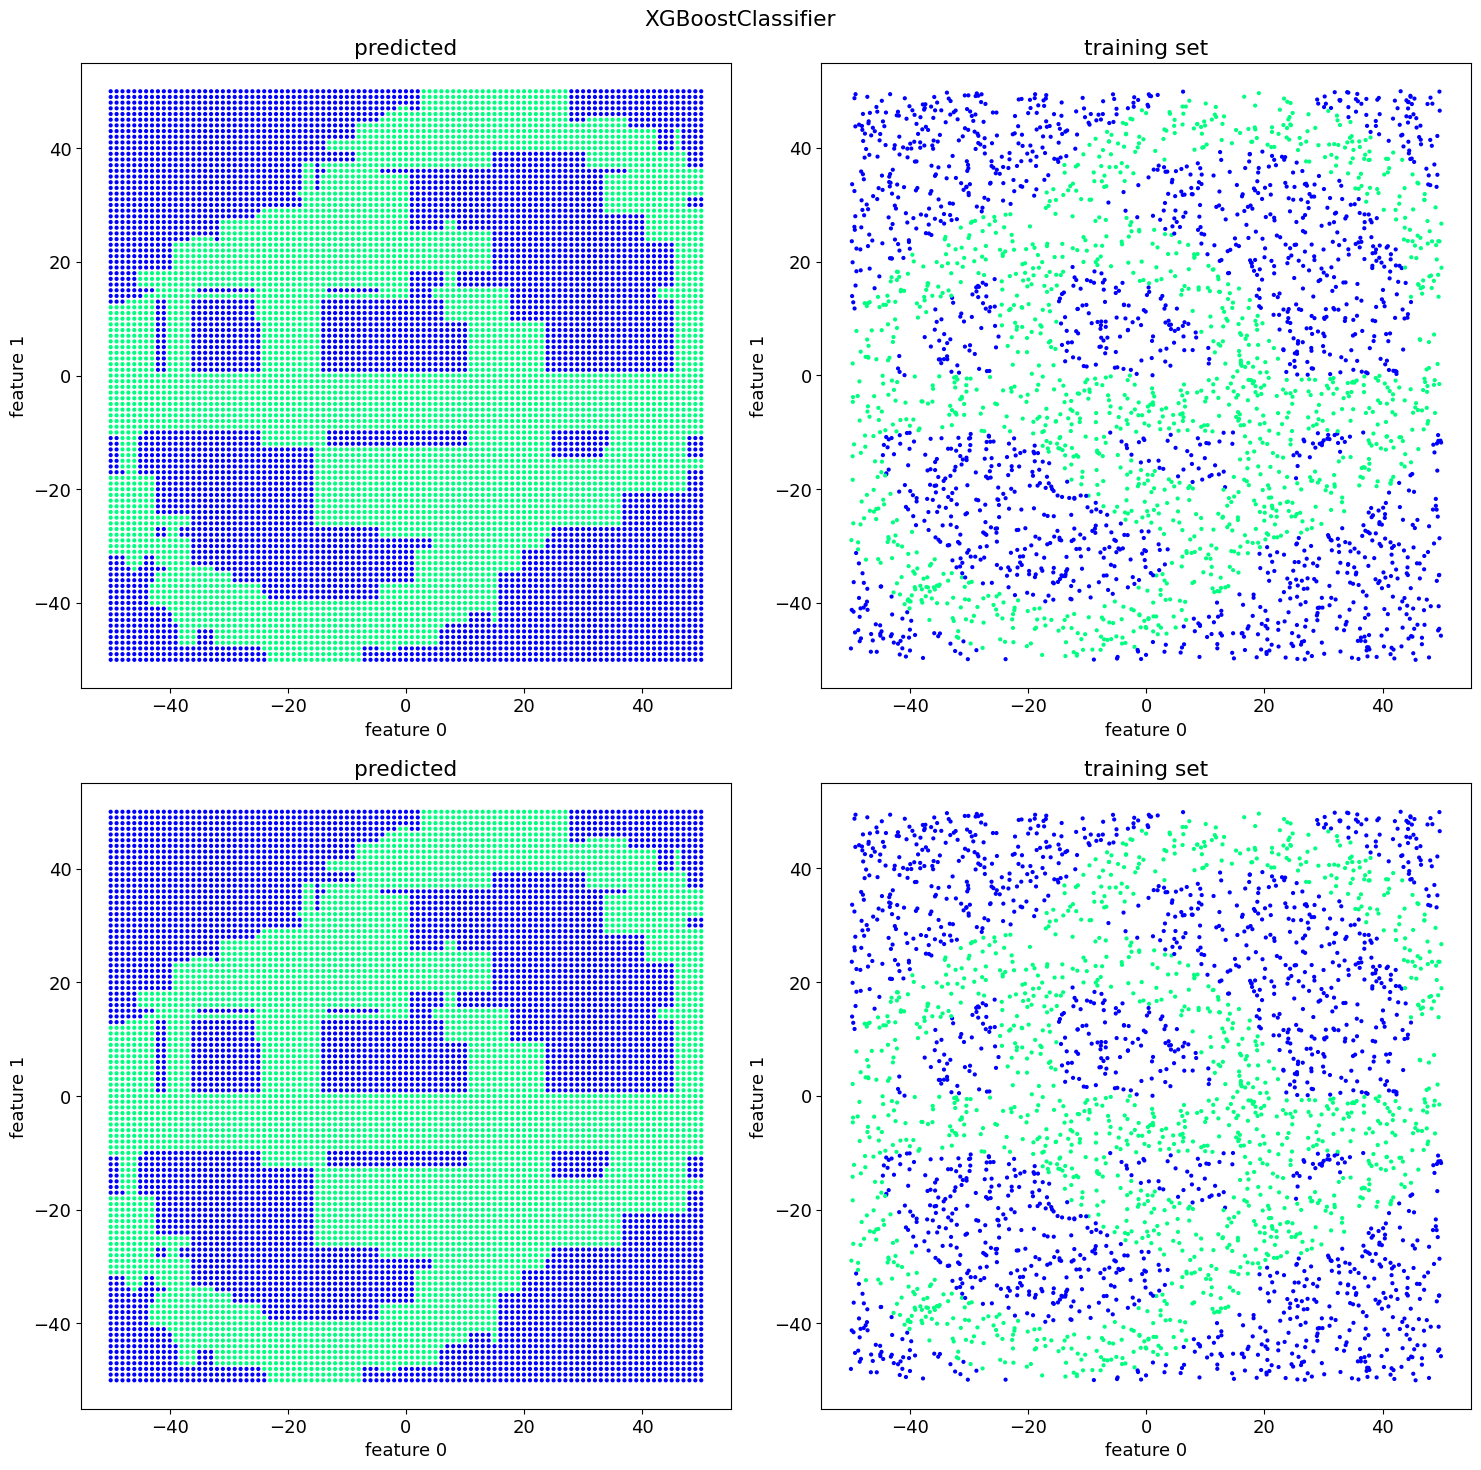

In [15]:
best_parameters['eval_metric'] = 'logloss'

#fig, axs = plt.subplots(3, 3) #figura 3 x 3 
#axs = axs.flatten() 

t = 0
dx = 0.1
dm = 5

eta = best_parameters['eta'] 
gamma = best_parameters['gamma']
max_leaves = best_parameters['max_leaves']

par3 = params.copy() 
SAVE = []

N = 300
accuracy = []
accuracy2 = []

while t != 10:
    #par3['eta'] = eta 
    #par3['gamma'] = gamma
    #par3['max_leaves'] = max_leaves

    model2 = XGBClassifier(seed = 1, objective = 'binary:logistic', learning_rate = par3['eta'], n_estimators = par3['n_estimators'], max_leaves = par3['max_leaves'], gamma = par3['gamma'])
    
    #model = GradientBoostingClassifier(learning_rate = par3['eta'], n_estimators = par3['n_estimators'],  max_depth = par3['max_depth'])
    
    #model = AdaBoostClassifier(algorithm='SAMME', n_estimators = N, learning_rate = par3['eta'] )
    
    SAVE.append([par3['eta'], par3['n_estimators'], par3['max_depth'], par3['gamma']])

    accuracy.append(classify(model, plot_flag=False))
    accuracy2.append(classify(model2, plot_flag=False))

    par3['eta'] += dx 
    par3['subsample'] -= dx
    par3['n_estimators'] += dm * 10
    par3['max_leaves'] += dm 
    par3['gamma'] += dx 

    N += dm * 20
    t += 1 
    
    
PAR = SAVE[np.argmax(accuracy)]
PAR_ = SAVE[np.argmin(accuracy)]

PAR2 = SAVE[np.argmax(accuracy2)] #parametri del modello migliore
PAR2_ =  SAVE[np.argmax(accuracy2)] #parametri del modelo peggiore



fig, AX = plt.subplots(2, 2, figsize = (15, 15))


model = GradientBoostingClassifier(learning_rate = PAR[0], n_estimators = PAR[1],  max_depth = PAR[2])
model_ = GradientBoostingClassifier(learning_rate = PAR_[0], n_estimators = PAR_[1],  max_depth = PAR_[2])

xplot, yplot, xtrain, ytrain = classify(model, flag = True)


scat(AX[0][0], xplot, yplot, title = 'predicted')
scat(AX[0][1], xtrain, ytrain, title = 'training set')

fig.suptitle('GradientBoostingClassifier')

xplot, yplot, xtrain, ytrain = classify(model_, flag = True)

scat(AX[1][0], xplot, yplot, title = 'predicted')
scat(AX[1][1], xtrain, ytrain, title = 'training set')

fig.tight_layout()

plt.show() 

fig, AX = plt.subplots(2, 2, figsize = (15, 15))


model2 = XGBClassifier(seed = 1, objective = 'binary:logistic', learning_rate = PAR2[0], n_estimators = PAR2[1], max_leaves = PAR2[2], gamma = PAR2[3])
model2_ = XGBClassifier(seed = 1, objective = 'binary:logistic', learning_rate = PAR2_[0], n_estimators = PAR2_[1], max_leaves = PAR2_[2], gamma = PAR2_[3])
    
xplot, yplot, xtrain, ytrain = classify(model2, flag = True)

scat(AX[0][0], xplot, yplot, title = 'predicted')
scat(AX[0][1], xtrain, ytrain, title = 'training set')

fig.suptitle('XGBoostClassifier')

xplot, yplot, xtrain, ytrain = classify(model2_, flag = True)

scat(AX[1][0], xplot, yplot, title = 'predicted')
scat(AX[1][1], xtrain, ytrain, title = 'training set')

fig.tight_layout()


plt.show()

In this plot we compare the output of the GradientBoostingClassifier and the XGBoost using the best parameters found in the cell above. 
The two subplots are referred to the best and worst results of the algorithm: the upper one is the result with the best accuracy, while the lower one has the worst accuracy.
It is possible to observe that both GBC and XGB are giving good results in classification.
XGBoost is still preferred because is able to give good results without any tuning of the parameters before, while GradientBoostingClassifier need an autotuning of the parameters before applying the algorithm.

## Section 2 - Dimensionality reduction

Now we are investigating whether the XGBoost could benefit from a reduction in the features' dimensionality. We will exploit all the possible combinations of them and compare the outcomes.

In [16]:
L_list = [i for i in range(np.shape(x_train)[1])]

all_combinations = []
for r in range(1, len(L_list) + 1):
    all_combinations.extend(combinations(L_list, r))

print('All the possible feature combinations are the following.')
all_combinations

All the possible feature combinations are the following.


[(0,),
 (1,),
 (2,),
 (3,),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 2),
 (1, 3),
 (2, 3),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 3),
 (1, 2, 3),
 (0, 1, 2, 3)]

In [17]:
X_LIST = []
N_val = int(0.2*np.shape(x_train)[0])

for combin in all_combinations:
  X_LIST.append(x_train[:, combin])

Accuracy_list = []
for x in X_LIST:
  model = XGBClassifier(**best_parameters)
  model.fit(x[N_val:], y_train[N_val:])
  Accuracy_list.append(model.score(x[:N_val], y_train[:N_val]))

df = pd.DataFrame({'Features_combination': all_combinations, 'Reduced_dataset': X_LIST, 'Accuracy': Accuracy_list})

In [18]:
df

Features_combination                                    Reduced_dataset  \
0                  (0,)  [[-31.608], [46.451], [24.771], [-20.13], [46....   
1                  (1,)  [[-29.544], [15.318], [46.131], [15.641], [22....   
2                  (2,)  [[6.773], [24.891], [-49.161], [30.981], [14.2...   
3                  (3,)  [[9.554], [15.357], [-39.356], [37.218], [21.7...   
4                (0, 1)  [[-31.608, -29.544], [46.451, 15.318], [24.771...   
5                (0, 2)  [[-31.608, 6.773], [46.451, 24.891], [24.771, ...   
6                (0, 3)  [[-31.608, 9.554], [46.451, 15.357], [24.771, ...   
7                (1, 2)  [[-29.544, 6.773], [15.318, 24.891], [46.131, ...   
8                (1, 3)  [[-29.544, 9.554], [15.318, 15.357], [46.131, ...   
9                (2, 3)  [[6.773, 9.554], [24.891, 15.357], [-49.161, -...   
10            (0, 1, 2)  [[-31.608, -29.544, 6.773], [46.451, 15.318, 2...   
11            (0, 1, 3)  [[-31.608, -29.544, 9.554], [46.451, 15.318, 1...   
12            (0, 2, 3)  [[-31.608, 6.773, 9.554], [46.451, 24.891, 15....   
13            (1, 2, 3)  [[-29.544, 6.773, 9.554], [15.318, 24.891, 15....   
14         (0, 1, 2, 3)  [[-31.608, -29.544, 6.773, 9.554], [46.451, 15...   

    Accuracy  
0   0.571667  
1   0.668333  
2   0.566667  
3   0.531667  
4   0.928333  
5   0.561667  
6   0.548333  
7   0.625000  
8   0.643333  
9   0.518333  
10  0.915000  
11  0.911667  
12  0.543333  
13  0.631667  
14  0.910000

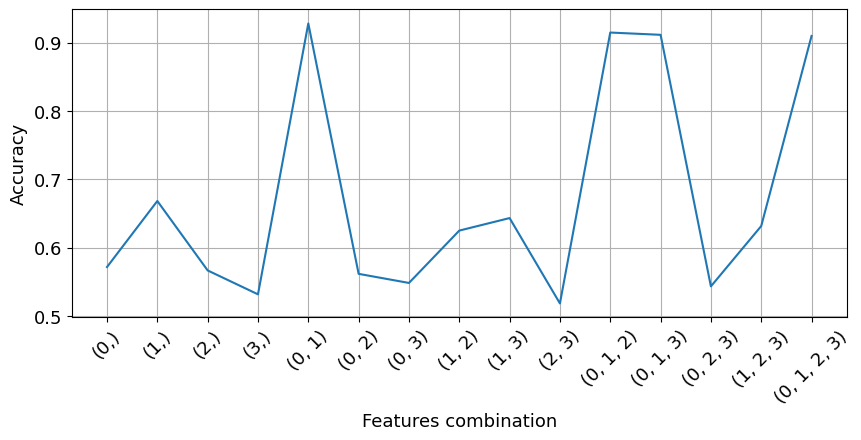

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.plot(df.index, df.Accuracy)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Features combination')
ax.set_xticks(df.index)
ax.set_xticklabels(df.Features_combination, rotation=45)

plt.grid()
plt.show()

It can be noted that the best accuracy is obtained for the model fitting with only the first two features L=0,1. This is to be expected, as these are the only features containing information, and the elimination of the noise related to L=2,3 makes the model more accurate. The worst values are instead obtained whenever one of L=0,1 is not considered, as the correlation between them is the key feature of this dataset.

## Section 3 - XGBoost vs NN 

### NN tuning and train

We want to compare the XGBoost algorithm with a classical dense feed-forward neural network. Since the number of samples within the set is limited, we use 5-fold cross validation. Furthermore, for simplicity, we decided to compare them only on the reduced problem with 2 features. For the paper we could extend this comparison to the whole 4-dimensional problem.

In [14]:
NFOLD       = 5
NEPOCHS     = 300
BATCHSIZE   = 32

x_train_reduced = x_train[:, :2]
y_train_reduced = y_train
N, L = len(x_train_reduced), len(x_train_reduced[0])

We define some useful functions to perform the Neural Network training.

In [15]:
#Model definitions
def build_model(n_neurons: np.ndarray, dropout_list: np.ndarray, lamb, input_shape = 2):
    '''
    n_neurons:         np.array containing the number of neurons for every layer.
                       Also the number of input and output neurons must be specified.
    dropout_list:      np.array containing the droput coefficients. Implemented only for hidden layers.
    lamb:              parameters to control the L2 regularization.
    input_shape:       Define the number of input neurons.
    '''
    #declare the model. Feed Forward -> Sequential
    model = Sequential()
    #adding input layer
    model.add(InputLayer(input_shape=(input_shape, ), name='Input_Layer'))

    #adding hidden layers
    for neurons, dropout in zip(n_neurons[:-1], dropout_list):
        model.add(Dense(neurons, activation='relu', kernel_regularizer = keras.regularizers.L2(lamb)))
        model.add(Dropout(dropout))
    #adding output layer
    model.add(Dense(n_neurons[-1],activation='sigmoid', kernel_regularizer = keras.regularizers.L2(lamb)))

    print(model.summary())
    return model

In [16]:
def DNN_KFold(DNN_model, lr, _verbose=0, flag = True, N_prime=x_train_reduced.shape[0]):
    '''
    DNN_model:     The model to be evaluated.
    lr:            Learning rate of the Adam optimizer.
    flag:          To stop the training process at the first iteration.
    N_prime:       The subset of the training set to be used.
    '''
    
    global NFOLD, NEPOCHS, BATCHSIZE
    kfold = KFold(n_splits=NFOLD, shuffle=True)
    x_fold = x_train_reduced[:N_prime, :]
    y_fold = y_train_reduced[:N_prime]
    
    # Define per-fold score containers
    acc_per_fold = []
    loss_per_fold = []

    fold_no = 1
    model = None
    history = None
    for train, val in kfold.split(x_fold, y_fold):

        # Define the model architecture
        model = tf.keras.models.clone_model(DNN_model, input_tensors=None, clone_function=None)

        adam = Adam(learning_rate = lr)

        # Compile the model
        model.compile(  loss='binary_crossentropy',
                        optimizer=adam,
                        metrics=['accuracy'])

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(x_fold[train], y_fold[train],
                            validation_data = (x_fold[val], y_fold[val]),
                            batch_size=BATCHSIZE,
                            epochs=NEPOCHS,
                            shuffle = True,
                            verbose=_verbose)

        # Evaluate the model
        scores = model.evaluate(x_fold[val], y_fold[val], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no += 1

        if(flag):
            break  #<-- RICORDA DI RIMUOVERE

    # Print average scores
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')
    return model, history, np.mean(acc_per_fold), np.std(acc_per_fold), np.mean(loss_per_fold), np.std(loss_per_fold)

In [17]:
#It displays the region of classification of the DNN
def DNN_show_margins(model):
    S=max(x_train_reduced[:, 0])
    dx = S/50
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot = model.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train_reduced[:],y_train_reduced,title="training set")
    fig.tight_layout()
    plt.show()

In [18]:
#Function to plot the training and validation accuracy as functions of the epochs 
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,NEPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

With a quick grid search we aim to define a good set of hyperparameters to train the network.

We are trying different configurations of the number of layers and neurons, together with a small number of dropouts, learning rates and L2 regularization parameter.

To save running time we are stopping the 5-fold cross validation at the first iteration.

In [25]:
NN_LAYERS       = [[128, 64, 1], [64, 32, 1], [128, 64, 32, 1], [64, 32, 16, 1], [128, 64, 32, 16, 1], [64, 32, 16, 8, 1], [128, 64, 32, 16, 8, 1]]
DROPOUTS        = [0.15, 0.3]
LEARNING_RATES  = [10 ** (-2), 10 ** (-3), 10 ** (-4)]
LAMBDAS         = [10 ** (-2), 10 ** (-3), 10 ** (-4)]

In [ ]:
%%capture grid_output

trained_model_grid, history_grid, acc_grid, acc_std_grid ,loss_grid, loss_std_grid = [], [], [], [], [], []

n_run = 0
total_time = 0.0

f = open('grid.txt', 'a')

for LAYER in NN_LAYERS:
    for drop_value in DROPOUTS:
        DROP = [drop_value for il in range(len(LAYER)-1)]
        for RATE in LEARNING_RATES:
            for LAMBDA in LAMBDAS:
                n_run += 1
                print("----------------------------------------------------------")
                print(f"RUN NUMBER {n_run}")
                start = time.time()
                
                net = build_model(LAYER, DROP, LAMBDA)
                trained_model, history, acc, acc_std, loss, loss_std = DNN_KFold(net, RATE)
                trained_model_grid.append(trained_model)
                history_grid.append(history)
                acc_grid.append(acc)
                acc_std_grid.append(acc_std)
                loss_grid.append(loss)
                loss_std_grid.append(loss_std)
                
                total_time += time.time() - start
                print(f"Time for the run: {time.time() - start}")
                print(f"Total time: {total_time}")
                print()

                f.write(f"{LAYER},{drop_value},{RATE},{LAMBDA},{acc}\n")
                f.flush()

f.close()

Analysis of the results of the grid search.

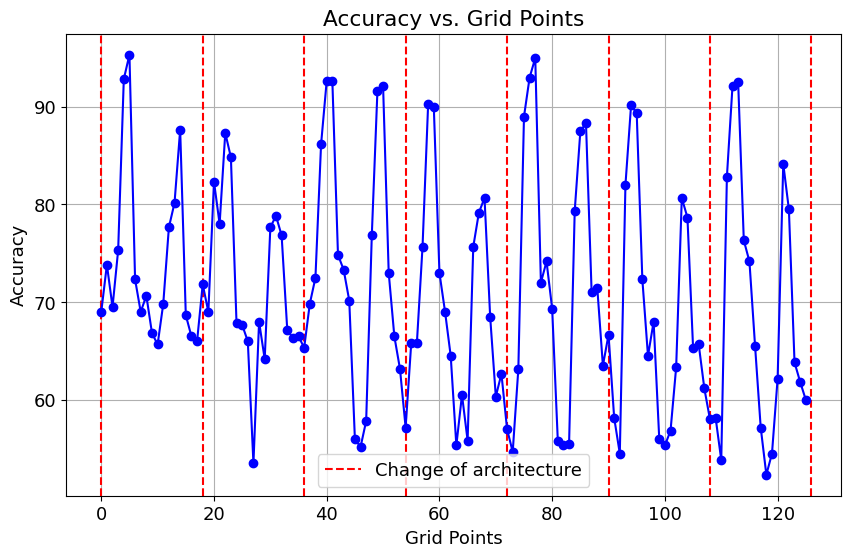

In [29]:
# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(acc_grid)), acc_grid, yerr=acc_std_grid, fmt='o', color='b', ecolor='r', linestyle='-')
for i in range(len(NN_LAYERS)):
    
    plt.axvline( (i+1) * (len(DROPOUTS)*len(LEARNING_RATES)*len(LAMBDAS)), color = 'r', linestyle = '--')
plt.axvline(0, color = 'r', linestyle = '--',label = 'Change of architecture')

plt.title('Accuracy vs. Grid Points')
plt.xlabel('Grid Points')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

We decide to keep only those configurations that have a validation accuracy greater than 90%. For the paper we will produce some plots to investigate the interdependencies of the parameters and how they affect the accuracy.

To select the best model, we perform a full 5-fold cross-validation.

In [11]:
NN_LAYERS       = [[128, 64, 1], [128, 64, 1], [128, 64, 32, 1], [128, 64, 32, 1], [128, 64, 32, 1], [128, 64, 32, 1], [64, 32, 16, 1], [128, 64, 32, 16, 1], [128, 64, 32, 16, 1], [64, 32, 16, 8, 1], [128, 64, 32, 16, 8, 1], [128, 64, 32, 16, 8, 1]]
DROPOUTS        = [0.15, 0.15, 0.15, 0.15, 0.3, 0.3, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]
LEARNING_RATES  = [10 ** (-3)]
LAMBDAS         = [10 ** (-3), 10 ** (-4), 10 ** (-3), 10 ** (-4), 10 ** (-3), 10 ** -(4), 10 ** (-3), 10 ** (-3), 10 ** -(4), 10 ** (-3), 10 ** (-3), 10 ** -(4)]

In [ ]:
%%capture model_validation_output

trained_model_list, history_list, acc_list, acc_std_list ,loss_list, loss_std_list = [], [], [], [], [], []

n_run = 0
total_time = 0.0

f = open('validation.txt', 'a')

for LAYER, LAMBDA, drop_value in zip(NN_LAYERS, LAMBDAS, DROPOUTS):
    DROP = [drop_value for il in range(len(LAYER)-1)]
    for RATE in LEARNING_RATES:
        n_run += 1
        print("----------------------------------------------------------")
        print(f"RUN NUMBER {n_run}")
        start = time.time()
        
        net = build_model(LAYER, DROP, LAMBDA)
        trained_model, history, acc, acc_std, loss, loss_std = DNN_KFold(net, RATE, flag = False)
        trained_model_list.append(trained_model)
        history_list.append(history)
        acc_list.append(acc)
        acc_std_list.append(acc_std)
        loss_list.append(loss)
        loss_std_list.append(loss_std)
        
        total_time += time.time() - start
        print(f"Time for the run: {time.time() - start}")
        print(f"Total time: {total_time}")
        print()

        f.write(f"{LAYER},{drop_value},{RATE},{LAMBDA},{acc}\n")
        f.flush()

f.close()

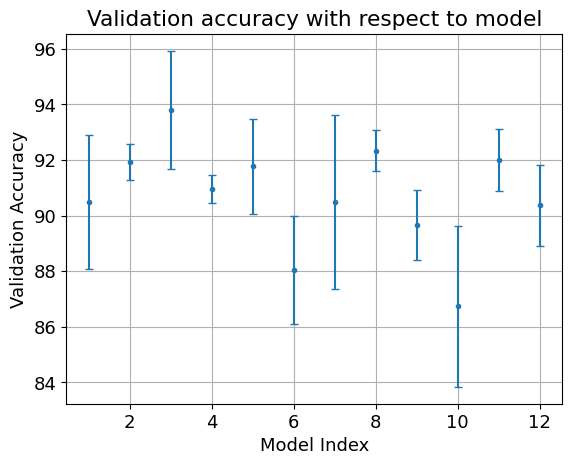

In [14]:
plt.errorbar((np.arange(n_run)+1), acc_list, yerr = acc_std_list, capsize=3, fmt=".")

plt.xlabel("Model Index")
plt.ylabel("Validation Accuracy")
plt.title('Validation accuracy with respect to model')
plt.grid()
plt.show()

The best best DNN model to tackle this classification is the third one, having:
* 128, 64 and 32 neurons inside the two hidden layers;
* 15% of dropout
* $\lambda = 10^{-3}$
* $10^{-3}$ for the Adam's learning rate

To extrapolate the maximum information about the model we retrain it with the hole training dataset and evaluate its performance with the test set.

In [19]:
best_DNN = build_model([128, 64, 32, 1], [0.15, 0.15, 0.15], 10**(-3))
best_lr = 10**-3
adam = Adam(learning_rate = best_lr)

# Compile the model
best_DNN.compile(loss='binary_crossentropy',
                 optimizer=adam,
                 metrics=['accuracy'])

best_history = best_DNN.fit( x_train_reduced, y_train_reduced,
                             validation_data = (x_test[:,:2], y_test),
                             batch_size=BATCHSIZE,
                             epochs=NEPOCHS,
                             shuffle = True,
                             verbose=0)

# Evaluate the model
scores = best_DNN.evaluate(x_test[:, :2], y_test, verbose=1)

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

None
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.9289 - loss: 0.2416


319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


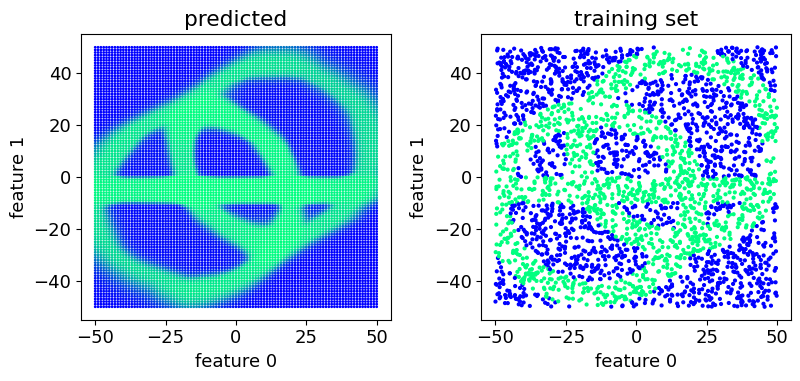

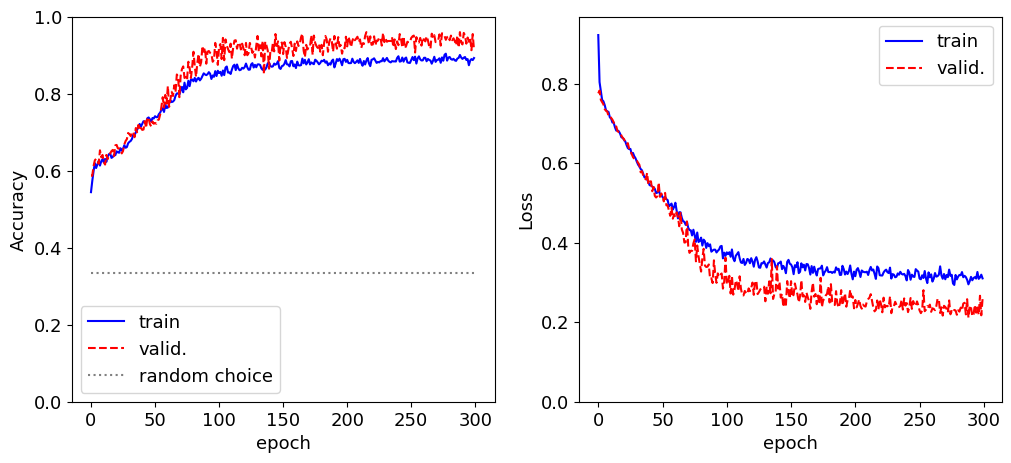

In [20]:
DNN_show_margins(best_DNN)
Show_history(best_history)

As we can see the model can reproduce the complex shape of the dataset and reach accuracies higher than 90%.

### Comparison with XGBoost

The comparison between the two methods is performed varying the number of training samples.

In [21]:
%%capture comparison_output

# Varying the number of data samples N' for XGBoost
frac = np.linspace(0.1, 0.9, 9) #fraction N' / N of the dataset 

ACCURACY_XGB = []
ACCURACY_DNN = []

for i in frac:
    N_prime = int(N * i) 

    _, _, acc, acc_std, _, _ = DNN_KFold(best_DNN, best_lr, flag = False, N_prime=N_prime)
    
    _, accuracy_XGB = kfold_validation(XGBClassifier(seed = 1, **best_parameters),  N_prime=N_prime, n_features=2)
    
    ACCURACY_XGB.append(accuracy_XGB)
    ACCURACY_DNN.append(acc)

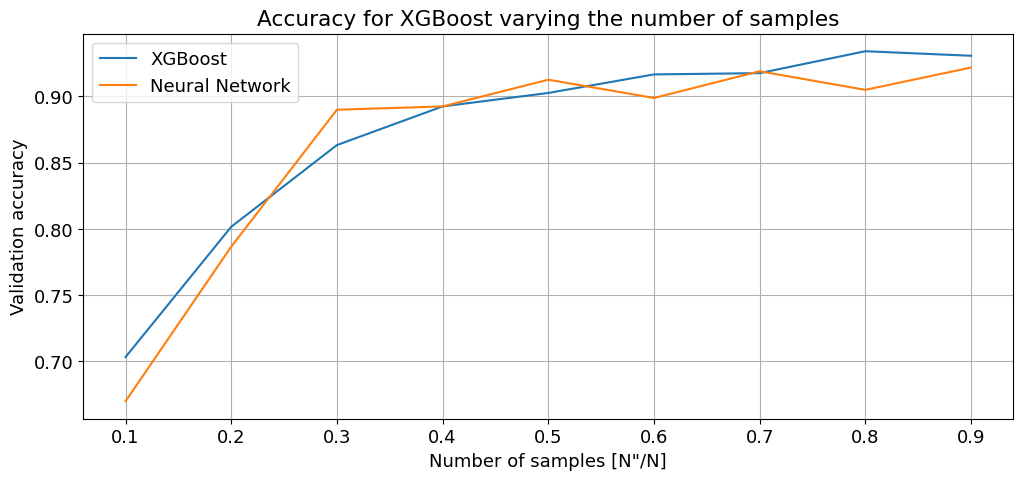

In [23]:
figure = plt.figure(figsize = (12, 5))
plt.plot(frac, ACCURACY_XGB, label = 'XGBoost')
plt.plot(frac, np.array(ACCURACY_DNN)/100, label = 'Neural Network')
plt.grid()
plt.xlabel('Number of samples [N"/N]')
plt.ylabel('Validation accuracy')
plt.title('Accuracy for XGBoost varying the number of samples')

plt.legend()
plt.show()

From this graph we can conclude that we have found a particular configuration of a feed-forward neural network whose performance is comparable to that of XGBoost.

However, we must bear in mind that the effort to train the NN was really greater than that to train XGBoost, and the former model is quite complex. So, overall, XGBoost is really more effective for this classification task. 